# Generate reaction classes for ORDerly_Condition

In [ ]:
# All this code is from: https://github.com/rxn4chemistry/rxnfp
# pip install rxnfp didn't work because I didn't have a rust compiler, so I had to install that first:
# https://huggingface.co/docs/tokenizers/installation
#

# Generate transformer FP

In [2]:
import rxnfp

In [3]:
# We can use the rxnfp readme instructions to generate the transformer FP
from rxnfp.transformer_fingerprints import (
    RXNBERTFingerprintGenerator, get_default_model_and_tokenizer, generate_fingerprints
)

model, tokenizer = get_default_model_and_tokenizer()

rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)

example_rxn = "Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1"

fp = rxnfp_generator.convert(example_rxn)
print(len(fp))
print(fp[:5])

/Users/dsw46/mambaforge/envs/rxnfp/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


256
[-2.01749587059021, 1.7602035999298096, -1.3323538303375244, -1.1095025539398193, 1.2254555225372314]


In [4]:
fps = rxnfp_generator.convert_batch([example_rxn, example_rxn])
print(len(fps), len(fps[0]))

2 256


In [5]:
# Train classifier
import json
import copy
import random
import pandas as pd
import numpy as np
from sklearn import metrics
import random
from sklearn.linear_model import LogisticRegression

In [6]:
#hide
def evaluate_model(model, fingerprints, corresponding_classes, all_classes, all_classes_names):
    
    preds = model.predict(fingerprints)
    predicted_classes = [all_classes[x] for x in preds]
    expected_classes =[all_classes[x] for x in corresponding_classes]

    confusion_matrix = metrics.confusion_matrix(corresponding_classes, preds)
    colCounts = confusion_matrix.sum(axis=0)
    rowCounts = confusion_matrix.sum(axis=1)

    print(' & recall & prec & F-score  &   reaction class &  \\\\ ')
    sum_recall=0
    sum_prec=0
    for i, rxn_class in enumerate(all_classes):
        recall = 0
        if rowCounts[i] > 0:
            recall = float(confusion_matrix[i,i])/rowCounts[i]
        sum_recall += recall
        prec = 0
        if colCounts[i] > 0:
            prec = float(confusion_matrix[i,i])/colCounts[i]
        sum_prec += prec
        f_score = 0
        if (recall + prec) > 0:
            f_score = 2 * (recall * prec) / (recall + prec)   
        print('{:2d} & {:.4f} & {:.4f} &{:.4f} & {:9s} &{:s} \\\\'.format(i, recall, prec, f_score, all_classes_names[rxn_class], rxn_class))
    
    mean_recall = sum_recall/len(all_classes)
    mean_prec = sum_prec/len(all_classes)
    if (mean_recall+mean_prec) > 0:
        mean_fscore = 2*(mean_recall*mean_prec)/(mean_recall+mean_prec)
    print(" &  {:.2f} & {:.2f} & {:.2f} & Average & \\\\ ".format(mean_recall,mean_prec,mean_fscore))
    
    return confusion_matrix

def labelled_cmat(confusion_matrix, labels,
                  figsize=(20,15), label_extras=None, 
                  dpi=300,threshold=0.01, 
                  xlabel=True, ylabel=True, rotation=90):
    from matplotlib import pyplot as plt
    
    rowCounts = confusion_matrix.sum(axis=1)
    cmat_percent = confusion_matrix/rowCounts[:,None]
    #zero all elements that are less than 1% of the row contents
    ncm = cmat_percent*(cmat_percent>threshold)

    fig = plt.figure(1,figsize=figsize,dpi=dpi)
    ax = fig.add_subplot(1,1,1)
    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)
    # pax=ax.pcolor(ncm,cmap=cm.ocean_r)
    # pax=ax.pcolor(ncm,cmap='gist_earth_r')

    pax=ax.pcolor(ncm,cmap='terrain_r')
    ax.set_frame_on(True)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(confusion_matrix.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(confusion_matrix.shape[1])+0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    if label_extras is not None:
        labels = [' {:s} {:s}'.format(x,label_extras[x].strip()) for x in labels]
    
    ax.set_xticklabels([], minor=False) 
    ax.set_yticklabels([], minor=False)

    if xlabel:
        ax.set_xticklabels(labels, minor=False, rotation=rotation, horizontalalignment='left') 
    if ylabel:
        ax.set_yticklabels(labels, minor=False)

    ax.grid(True)
    fig.colorbar(pax)
    fig.tight_layout()
    return fig

In [9]:
# data
with open('../rxnfp/data/rxnclass2id.json', 'r') as f:
    rxnclass2id = json.load(f)

with open('../rxnfp/data/rxnclass2name.json', 'r') as f:
    rxnclass2name = json.load(f)
all_classes =sorted(rxnclass2id.keys())

In [13]:
# data
import pickle
schneider_df = pd.read_csv('../rxnfp/data/schneider50k.tsv', sep='\t', index_col=0)
ft_10k_fps = np.load('../rxnfp/data/fps_ft_10k.npz')['fps']
ft_pretrained = np.load('../rxnfp/ata/fps_pretrained.npz')['fps']
schneider_df['ft_10k'] = [fp for fp in ft_10k_fps]
schneider_df['ft_pretrained'] = [fp for fp in ft_pretrained]
schneider_df['class_id'] = [rxnclass2id[c] for c in schneider_df.rxn_class]
schneider_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../rxnfp/ata/fps_pretrained.npz'

In [2]:
import pandas as pd

In [3]:
df = pd.read_pickle('/Users/dsw46/Downloads/uspto_50.pickle')

In [9]:
df.columns

Index(['reactants_mol', 'products_mol', 'reaction_type', 'set'], dtype='object')

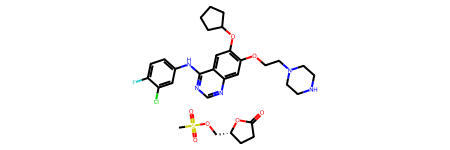

In [10]:
df['reactants_mol'][0]